## SETUP AND IMPORTS


In [1]:

import os
import re
import random as rn
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## SEED CONTROL

In [2]:

SEED = 12345
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

## UTILITY FUNCTIONS

In [3]:

def preprocess(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    return scaled, scaler

def extract_VC_capacity(x_datasets, y_datasets, seq_len=5, hop=1, sample=10):
    from pandas import read_csv, DataFrame
    V, C = [], []
    x, y = [], []

    for x_data, y_data in zip(x_datasets, y_datasets):
        x_df = read_csv(x_data).dropna()
        x_df = x_df[['cycle', 'voltage_battery']]
        x_df = x_df[x_df['cycle'] != 0].reset_index(drop=True)

        y_df = read_csv(y_data).dropna()
        y_df['cycle_idx'] = y_df.index + 1
        y_df = y_df[['capacity', 'cycle_idx']].values.astype('float32')

        for i in range(len(y_df)):
            cy = x_df.cycle.unique()[i]
            df = x_df.loc[x_df['cycle'] == cy]
            cap = np.array([y_df[i, 0]])
            C.append(cap)
            df_C = DataFrame(C).values
            scaled_C, scaler_C = preprocess(df_C)
            scaled_C = scaled_C.astype('float32')

            le = len(df['voltage_battery']) % sample
            vTemp = df['voltage_battery'].to_numpy()
            if le != 0:
                vTemp = vTemp[0:-le]
            vTemp = np.reshape(vTemp, (len(vTemp)//sample, -1), order="F")
            vTemp = vTemp.mean(axis=0)
            V.append(vTemp)
            df_V = DataFrame(V).values
            scaled_V, _ = preprocess(df_V)
            scaled_V = scaled_V.astype('float32')

            VC_temp = np.concatenate([scaled_V, scaled_C], axis=1)

        data_len = np.int32(np.floor((len(y_df) - seq_len - 1) / hop)) + 1
        for i in range(data_len):
            x.append(VC_temp[(hop * i):(hop * i + seq_len)])
            y.append(scaled_C[hop * i + seq_len])
    return np.array(x), np.array(y), scaler_C

def evaluate_model(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n📊 {label} Results:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(8,5))
    plt.plot(y_true, label="True", lw=2)
    plt.plot(y_pred, label="Predicted", lw=2)
    plt.title(title)
    plt.xlabel("Cycle")
    plt.ylabel("Capacity")
    plt.legend()
    plt.show()

## DATA PATHS

In [4]:
base_path = "data/NASA/" 
train_x_files = [os.path.join(base_path, 'charge/train', f) for f in sorted(os.listdir(os.path.join(base_path, 'charge/train')), key=lambda f: int(re.sub(r'\D', '', f)))]
train_y_files = [os.path.join(base_path, 'discharge/train', f) for f in sorted(os.listdir(os.path.join(base_path, 'discharge/train')), key=lambda f: int(re.sub(r'\D', '', f)))]

test_x_files = [os.path.join(base_path, 'charge/test', f) for f in os.listdir(os.path.join(base_path, 'charge/test'))]
test_y_files = [os.path.join(base_path, 'discharge/test', f) for f in os.listdir(os.path.join(base_path, 'discharge/test'))]


## DATA EXTRACTION

In [5]:
trainX, trainY, scaler = extract_VC_capacity(train_x_files, train_y_files, seq_len=5, hop=1, sample=10)
testX, testY, _ = extract_VC_capacity(test_x_files, test_y_files, seq_len=5, hop=1, sample=10)
print("Train shape:", trainX.shape, "Test shape:", testX.shape)

inv_trainY = scaler.inverse_transform(trainY)
inv_testY = scaler.inverse_transform(testY)


Train shape: (489, 5, 11) Test shape: (127, 5, 11)


### 2. BASIC Deep machine models

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to torch tensors
trainX_t = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY_t = torch.tensor(trainY, dtype=torch.float32).to(device)
testX_t = torch.tensor(testX, dtype=torch.float32).to(device)
testY_t = torch.tensor(testY, dtype=torch.float32).to(device)

batch_size = 16
train_loader = DataLoader(TensorDataset(trainX_t, trainY_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(testX_t, testY_t), batch_size=batch_size, shuffle=False)




In [19]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(BasicLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)  # Add batch norm
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.bn(out)   # normalize features
        out = self.fc(out)
        return out

class BasicGRU(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(BasicGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)  # Add batch norm
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        out = self.bn(out)   # normalize features
        out = self.fc(out)
        return out

class BasicCNN1D(nn.Module):
    def __init__(self, input_size):
        super(BasicCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)  # Add batch norm after conv
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64*((trainX.shape[1]-2)//2), 50)
        self.bn2 = nn.BatchNorm1d(50)  # Add batch norm after fc1
        self.fc2 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)         # normalize after conv
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn2(x)         # normalize after fc1
        x = self.relu(x)
        x = self.fc2(x)
        return x

class CNN_LSTM(nn.Module):
    def __init__(self, input_size, conv_channels=64, kernel_size=3, lstm_hidden=32):
        super(CNN_LSTM, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=conv_channels,
                              kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(conv_channels)  # Add batch norm after conv
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, batch_first=True)
        self.bn2 = nn.BatchNorm1d(lstm_hidden)    # Add batch norm after lstm
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)                # -> (batch, features, seq_len)
        x = self.conv(x)
        x = self.bn1(x)                       # normalize after conv
        x = self.relu(x)                      # -> (batch, conv_channels, seq_len)
        x = x.permute(0, 2, 1)               # -> (batch, seq_len, conv_channels)
        out, _ = self.lstm(x)                # -> (batch, seq_len, lstm_hidden)
        out = out[:, -1, :]                  # last time step
        out = self.bn2(out)                  # normalize features
        out = self.fc(out)                   # -> (batch, 1)
        return out


# ---------------------------
# CNN + LSTM + Attention hybrid
# ---------------------------
class CNN_LSTM_Attn(nn.Module):
    def __init__(self, input_size, conv_channels=48, lstm_hidden=48, attn_heads=2, kernel_size=3):
        super().__init__()
        # Convolutional front-end
        self.conv1 = nn.Conv1d(input_size, conv_channels, kernel_size=kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=kernel_size, padding=2, dilation=2)
        self.relu = nn.ReLU()
        self.bn_conv = nn.BatchNorm1d(conv_channels)
        
        # LSTM encoder with dropout
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, batch_first=True, bidirectional=True, dropout=0.2)
        self.ln_lstm = nn.LayerNorm(lstm_hidden * 2)
        
        # Multi-head attention
        self.attn = nn.MultiheadAttention(embed_dim=lstm_hidden*2,
                                          num_heads=attn_heads,
                                          batch_first=True,
                                          dropout=0.1)
        
        # Fully connected head
        self.fc1 = nn.Linear(lstm_hidden*2, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # CNN: (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn_conv(x)
        x = x.permute(0, 2, 1)  # -> (batch, seq_len, conv_channels)
        
        # LSTM
        out, _ = self.lstm(x)
        out = self.ln_lstm(out)
        
        # Attention with residual
        attn_out, _ = self.attn(out, out, out)
        out = out + attn_out
        
        # Attention-weighted pooling over time
        weights = torch.softmax(out.mean(dim=-1), dim=1).unsqueeze(-1)  # (batch, seq_len, 1)
        out = (out * weights).sum(dim=1)
        
        # Fully connected
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [20]:
# ---------------------------
# RMSE Loss
# ---------------------------
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

# ---------------------------
# Training function with scheduler
# ---------------------------
def train_model(model, train_loader, epochs=200, lr=1e-3, l1_lambda=1e-5, weight_decay=1e-4):
    model.to(device)
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            # L1 regularization
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss = loss + l1_lambda * l1_norm
                
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} - RMSE Loss: {epoch_loss/len(train_loader.dataset):.6f}")
        
    return model

In [23]:
input_size = trainX.shape[2]
deep_results = {}

# ---------------------------
# Basic LSTM
# ---------------------------
lstm_model = BasicLSTM(input_size)
train_model(lstm_model, train_loader)

lstm_model.eval()
with torch.no_grad():
    lstm_preds = lstm_model(testX_t).cpu().numpy()

# Use target scaler, not input scaler
inv_lstm_preds = scaler.inverse_transform(lstm_preds)
deep_results["Basic LSTM"] = evaluate_model(inv_testY, inv_lstm_preds, label="Basic LSTM")

# ---------------------------
# Basic GRU
# ---------------------------
gru_model = BasicGRU(input_size)
train_model(gru_model, train_loader)

gru_model.eval()
with torch.no_grad():
    gru_preds = gru_model(testX_t).cpu().numpy()

inv_gru_preds = scaler.inverse_transform(gru_preds)
deep_results["Basic GRU"] = evaluate_model(inv_testY, inv_gru_preds, label="Basic GRU")

# ---------------------------
# Basic 1D CNN
# ---------------------------
cnn_model = BasicCNN1D(input_size)
train_model(cnn_model, train_loader)

cnn_model.eval()
with torch.no_grad():
    cnn_preds = cnn_model(testX_t).cpu().numpy()

inv_cnn_preds = scaler.inverse_transform(cnn_preds)
deep_results["Basic 1D CNN"] = evaluate_model(inv_testY, inv_cnn_preds, label="Basic 1D CNN")

# ---------------------------
# CNN + LSTM hybrid
# ---------------------------
cnn_lstm_model = CNN_LSTM(input_size)
# example: enable L2 via weight_decay and run longer training
train_model(cnn_lstm_model, train_loader)

cnn_lstm_model.eval()
with torch.no_grad():
    cnn_lstm_preds = cnn_lstm_model(testX_t).cpu().numpy()

inv_cnn_lstm_preds = scaler.inverse_transform(cnn_lstm_preds)
deep_results["CNN + LSTM"] = evaluate_model(inv_testY, inv_cnn_lstm_preds, label="CNN + LSTM")



Epoch 1/200 - RMSE Loss: 0.349146
Epoch 2/200 - RMSE Loss: 0.231398
Epoch 3/200 - RMSE Loss: 0.133270
Epoch 4/200 - RMSE Loss: 0.090982
Epoch 5/200 - RMSE Loss: 0.078469
Epoch 6/200 - RMSE Loss: 0.075137
Epoch 7/200 - RMSE Loss: 0.066498
Epoch 8/200 - RMSE Loss: 0.081642
Epoch 9/200 - RMSE Loss: 0.092616
Epoch 10/200 - RMSE Loss: 0.063813
Epoch 11/200 - RMSE Loss: 0.064750
Epoch 12/200 - RMSE Loss: 0.064083
Epoch 13/200 - RMSE Loss: 0.076272
Epoch 14/200 - RMSE Loss: 0.076324
Epoch 15/200 - RMSE Loss: 0.074683
Epoch 16/200 - RMSE Loss: 0.070195
Epoch 17/200 - RMSE Loss: 0.075609
Epoch 18/200 - RMSE Loss: 0.075597
Epoch 19/200 - RMSE Loss: 0.071039
Epoch 20/200 - RMSE Loss: 0.071371
Epoch 21/200 - RMSE Loss: 0.069016
Epoch 22/200 - RMSE Loss: 0.075974
Epoch 23/200 - RMSE Loss: 0.076538
Epoch 24/200 - RMSE Loss: 0.067533
Epoch 25/200 - RMSE Loss: 0.063073
Epoch 26/200 - RMSE Loss: 0.079808
Epoch 27/200 - RMSE Loss: 0.079134
Epoch 28/200 - RMSE Loss: 0.060787
Epoch 29/200 - RMSE Loss: 0.0

In [21]:
# ---------------------------
# CNN + LSTM + Attention hybrid
# ---------------------------
cnn_lstm_attn_model = CNN_LSTM_Attn(input_size)
train_model(cnn_lstm_attn_model, train_loader)

cnn_lstm_attn_model.eval()
with torch.no_grad():
    preds = cnn_lstm_attn_model(testX_t).cpu().numpy()

inv_preds_lstm_cnn_attn = scaler.inverse_transform(preds)
deep_results["CNN + LSTM + Attention"] = evaluate_model(inv_testY, inv_preds_lstm_cnn_attn, label="CNN + LSTM + Attention")

Epoch 1/200 - RMSE Loss: 0.203028
Epoch 2/200 - RMSE Loss: 0.125653
Epoch 3/200 - RMSE Loss: 0.120737
Epoch 4/200 - RMSE Loss: 0.106052
Epoch 5/200 - RMSE Loss: 0.102677
Epoch 6/200 - RMSE Loss: 0.098921
Epoch 7/200 - RMSE Loss: 0.093148
Epoch 8/200 - RMSE Loss: 0.101280
Epoch 9/200 - RMSE Loss: 0.093050
Epoch 10/200 - RMSE Loss: 0.094566
Epoch 11/200 - RMSE Loss: 0.097101
Epoch 12/200 - RMSE Loss: 0.094908
Epoch 13/200 - RMSE Loss: 0.094614
Epoch 14/200 - RMSE Loss: 0.089753
Epoch 15/200 - RMSE Loss: 0.095762
Epoch 16/200 - RMSE Loss: 0.110496
Epoch 17/200 - RMSE Loss: 0.091336
Epoch 18/200 - RMSE Loss: 0.079304
Epoch 19/200 - RMSE Loss: 0.073517
Epoch 20/200 - RMSE Loss: 0.080849
Epoch 21/200 - RMSE Loss: 0.077955
Epoch 22/200 - RMSE Loss: 0.077811
Epoch 23/200 - RMSE Loss: 0.071274
Epoch 24/200 - RMSE Loss: 0.086398
Epoch 25/200 - RMSE Loss: 0.076141
Epoch 26/200 - RMSE Loss: 0.063476
Epoch 27/200 - RMSE Loss: 0.065335
Epoch 28/200 - RMSE Loss: 0.069728
Epoch 29/200 - RMSE Loss: 0.0

## RESULTS SUMMARY

In [22]:
import pandas as pd

all_results_torch = {**deep_results}
results_table_torch = pd.DataFrame(all_results_torch).T
print("\n=== Summary of All Models  ===")
display(results_table_torch)



=== Summary of All Models  ===


,MAE,MSE,RMSE,MAPE
Basic LSTM,0.044245,0.002723,0.052178,0.029857
Basic GRU,0.023374,0.001851,0.043019,0.015412
Basic 1D CNN,0.088868,0.013028,0.114139,0.057215
CNN + LSTM,0.031276,0.002281,0.047758,0.020589
CNN + LSTM + Attention,0.037887,0.003285,0.057319,0.024343


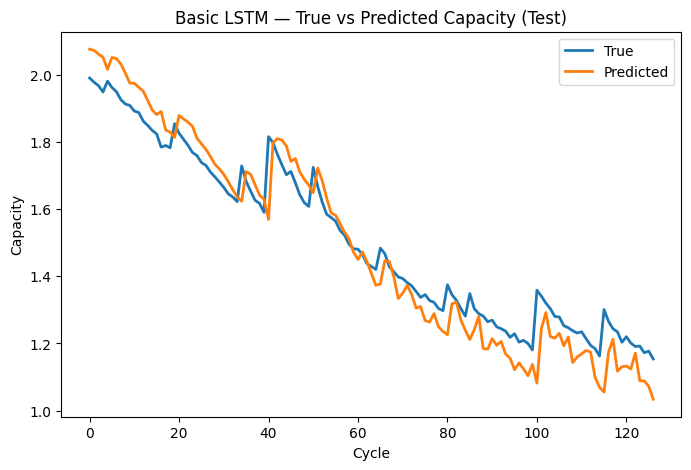

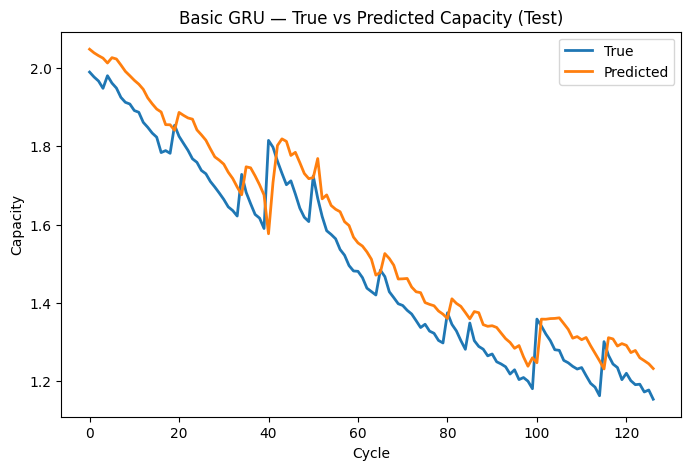

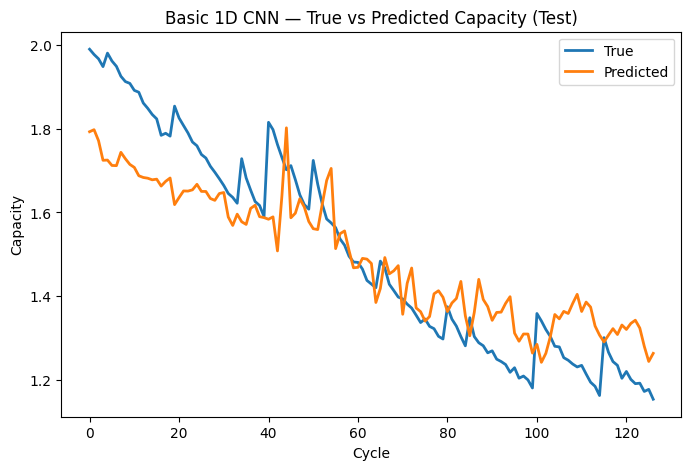

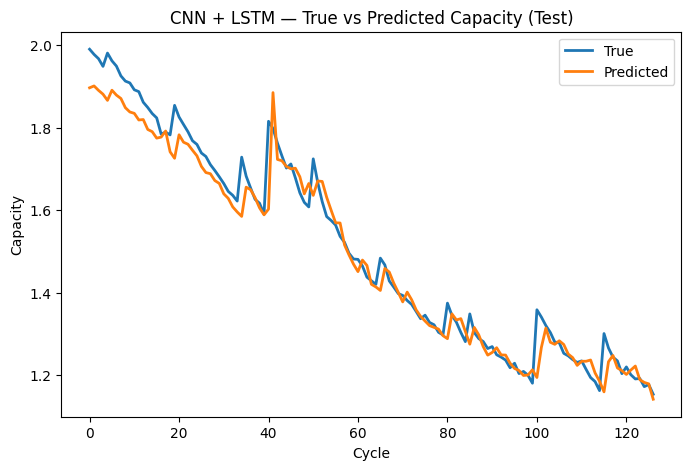

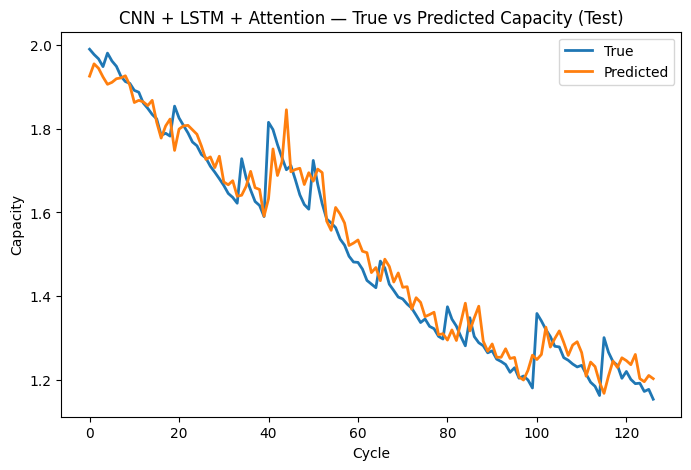

In [ ]:

# Plot test true vs predicted for all deep models using the existing plot_results function.
deep_preds = {
    "Basic LSTM": inv_lstm_preds,
    "Basic GRU": inv_gru_preds,
    "Basic 1D CNN": inv_cnn_preds,
    "CNN + LSTM": inv_cnn_lstm_preds,
    "CNN + LSTM + Attention": inv_preds_lstm_cnn_attn
}

for name, preds in deep_preds.items():
    try:
        plot_results(inv_testY, preds, f"{name} — True vs Predicted Capacity (Test)")
    except NameError as e:
        print(f"Skipping {name}: variable not found ({e})")

